# MNIST digits generation with DCGAN

We'll build a deep convolutional generative adversarial network (DCGAN) to generate images of hand-written digits from the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We will download the dataset from the `torchvision` package of PyTorch. 

Before downloading the dataset, we will define transforms and normalization that we will apply to the dataset through `torchvision.transforms` module. The transforms we will apply are follows:

1. We will resize the images to 64x64.
2. We will normalize the pixel values to be between -1 and 1.    `

This is because the DCGAN models expects the images to be of size 64x64 and the pixel values to be between -1 and 1.

In [1]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((64, 64)), # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5], inplace=True) # Normalize all images to [-1, 1]
    ]
)

We will apply the transforms created above to the training and test MNIST datasets.

The training and test datasets will be downloaded from the `torchvision.datasets` module, into the directory specified by the `root` argument. The `train` argument specifies whether to download the training or the test dataset by setting it to `True` or `False` respectively. Here, we will download the training dataset.

The `transform` argument specifies the transforms to be applied to the dataset. We will pass the transforms created above to this argument.

Set the `download` argument to `True` to download the dataset.

In [2]:
from torchvision import datasets

trainset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

We can now visualize some images from the training dataset using the `matplotlib` package.

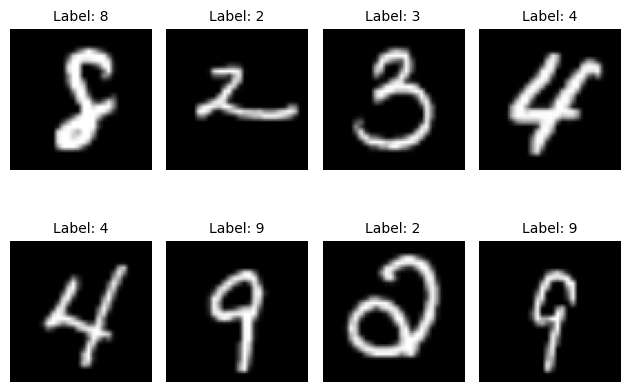

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flatten()):
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()] # randomly select an image from the training set
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=10)
	ax.axis("off")
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## DCGAN Generator and Discriminator

In this section we will define the generator and discriminator networks of the DCGAN model.

### Generator
We use the class `DCGANGenerator` from `deeplay` to define a deep convolutional generator network. It takes a latent vector (noise vector) of size 100 as input, as defined by the `latent_dim` parameter and outputs an image of size 64x64.

The output channels of the image is defined by the `output_channels` parameter. Here, the `output_channels` parameter is set to 1 as the MNIST dataset consists of grayscale images.

The generator network consists of 4 upsampling layers (convolutional transpose layers). Each layer is followed by a batch normalization layer and a ReLU activation. The last layer is followed by a tanh activation. The number of convolutional filters in each of the 4 transposed convolutional layers is defined by the `features_dim` parameter which results in `[features_dim * 16, features_dim * 8, features_dim * 4, features_dim * 2]` filters in the first, second, third and fourth layers respectively.

Once we define the models, we will move them to the device defined above.

In [5]:
import deeplay as dl

generator = dl.DCGANGenerator(
    latent_dim=100,
    output_channels=1,
    features_dim=64,
)
generator.build()

generator.to(device)

DCGANGenerator(
  (blocks): LayerList(
    (0): ConvTransposeBlock(
      (layer): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvTransposeBlock(
      (layer): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvTransposeBlock(
      (layer): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvTransposeBlock(
      (layer): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(128, eps=1e-05, m

### Discriminator
We use the class `DCGANDiscriminator` from `deeplay` to define a deep convolutional discriminator network. It takes an image of size 64x64 as input and outputs a single value between 0 and 1, indicating whether the input image is real or fake.

The input channels of the image is defined by the `input_channels` parameter. Here, the `input_channels` parameter is set to 1 as the MNIST dataset consists of grayscale images.

The discriminator network consists of 4 layers of convolutional layers. Each layer is followed by a batch normalization layer and a LeakyReLU activation layer. The number of convolutional filter in each of these is defined by the `features_dim` parameter, resulting in `[features_dim, features_dim * 2, features_dim * 4, features_dim * 8]` filters in the first, second, third and fourth layers respectively.

Once we define the models, we will move them to the device defined above.

In [6]:
discriminator = dl.DCGANDiscriminator(
    input_channels=1,
    features_dim=64,
)
discriminator.build()

discriminator.to(device)

DCGANDiscriminator(
  (blocks): LayerList(
    (0): ConvBlock(
      (layer): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): Identity()
    )
    (1): ConvBlock(
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (layer): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

### Optimizers

We will define the optimizer and learning rates for the generator and discriminator networks. We will use the Adam optimizer with a learning rate of 0.0002 for both the generator and discriminator networks as defined by the `lr` parameter, and the coefficients `beta1` and `beta2` set to 0.5 and 0.999 respectively. The coefficients `beta1` and `beta2` are used for computing running averages of gradient and its square.

In [7]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Loss function

We define a loss function for the discriminator and generator.

In [8]:
criterion = torch.nn.BCELoss()  # Binary cross entropy loss

### Training data loader
We now define the data loader for the training dataset. We will use a batch size of 128 as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` to shuffle the training dataset before creating batches.

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

### Training procedure

We will now define the training loop for the DCGAN model for generating MNIST digits from noise. 

We will train the model for 20 epochs as defined by the `EPOCHS` parameter. 

The `BATCH_SIZE` parameter defines the batch size to be used for training the model. We will define it to the same value as the batch size used for creating the training data loader. 

The `LATENT_DIM` parameter defines the size of the latent vector (noise vector) to be used as input to the generator network. We will define it to the same value as the latent dimension used for defining the generator network.




Epoch 1/20
----------


Batch 1/469 : Generator Loss: 0.8221, Discriminator Loss: 0.6958
Batch 201/469 : Generator Loss: 0.6824, Discriminator Loss: 0.6221
Batch 401/469 : Generator Loss: 1.1055, Discriminator Loss: 0.5925
----------
Epoch 1/20 : Generator Loss: 1.5734, Discriminator Loss: 0.4854
Time taken: 0:00:13.041393


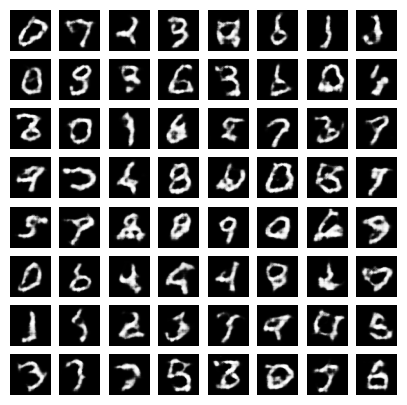



Epoch 2/20
----------
Batch 1/469 : Generator Loss: 0.8391, Discriminator Loss: 0.6141
Batch 201/469 : Generator Loss: 0.8722, Discriminator Loss: 0.6264
Batch 401/469 : Generator Loss: 0.8896, Discriminator Loss: 0.5571
----------
Epoch 2/20 : Generator Loss: 0.9494, Discriminator Loss: 0.6110
Time taken: 0:00:12.711882


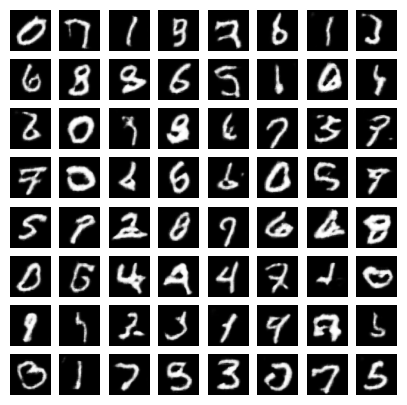



Epoch 3/20
----------
Batch 1/469 : Generator Loss: 0.7016, Discriminator Loss: 0.5181
Batch 201/469 : Generator Loss: 1.6255, Discriminator Loss: 0.4362
Batch 401/469 : Generator Loss: 2.4488, Discriminator Loss: 0.1053
----------
Epoch 3/20 : Generator Loss: 1.8172, Discriminator Loss: 0.3864
Time taken: 0:00:12.793029


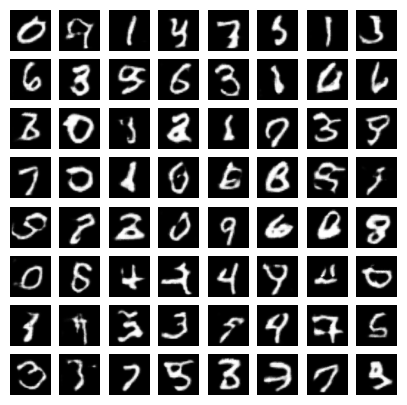



Epoch 4/20
----------
Batch 1/469 : Generator Loss: 0.8184, Discriminator Loss: 0.3052
Batch 201/469 : Generator Loss: 2.3513, Discriminator Loss: 0.1466
Batch 401/469 : Generator Loss: 2.2503, Discriminator Loss: 0.2092
----------
Epoch 4/20 : Generator Loss: 2.6893, Discriminator Loss: 0.2137
Time taken: 0:00:12.846905


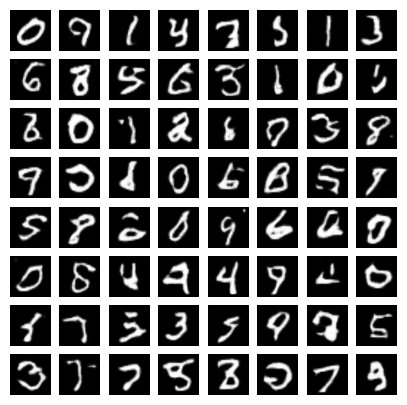



Epoch 5/20
----------
Batch 1/469 : Generator Loss: 2.8561, Discriminator Loss: 0.1205
Batch 201/469 : Generator Loss: 4.0690, Discriminator Loss: 0.0259
Batch 401/469 : Generator Loss: 1.7406, Discriminator Loss: 0.3231
----------
Epoch 5/20 : Generator Loss: 3.2345, Discriminator Loss: 0.1776
Time taken: 0:00:12.838681


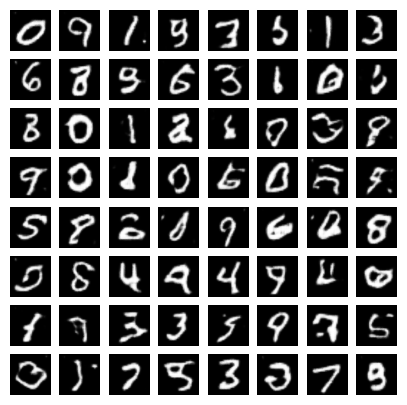



Epoch 6/20
----------
Batch 1/469 : Generator Loss: 4.0745, Discriminator Loss: 0.0276
Batch 201/469 : Generator Loss: 1.1834, Discriminator Loss: 0.5845
Batch 401/469 : Generator Loss: 3.6517, Discriminator Loss: 0.0329
----------
Epoch 6/20 : Generator Loss: 3.6168, Discriminator Loss: 0.1449
Time taken: 0:00:12.860426


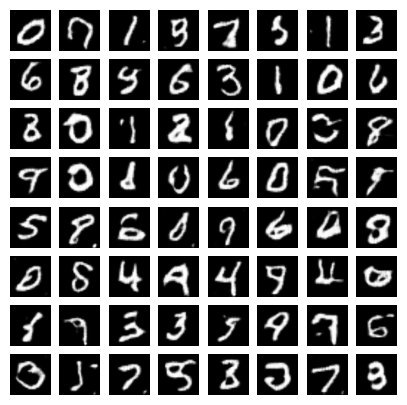



Epoch 7/20
----------
Batch 1/469 : Generator Loss: 4.1016, Discriminator Loss: 0.0259
Batch 201/469 : Generator Loss: 4.8077, Discriminator Loss: 0.0141
Batch 401/469 : Generator Loss: 0.9774, Discriminator Loss: 0.5996
----------
Epoch 7/20 : Generator Loss: 4.0890, Discriminator Loss: 0.1319
Time taken: 0:00:12.896398


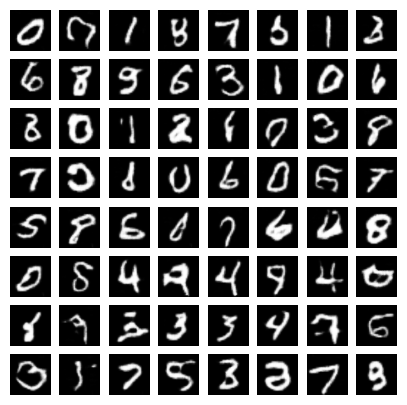



Epoch 8/20
----------
Batch 1/469 : Generator Loss: 0.7259, Discriminator Loss: 0.4986
Batch 201/469 : Generator Loss: 2.5060, Discriminator Loss: 0.3093
Batch 401/469 : Generator Loss: 2.5521, Discriminator Loss: 0.1531
----------
Epoch 8/20 : Generator Loss: 3.0067, Discriminator Loss: 0.2127
Time taken: 0:00:12.783603


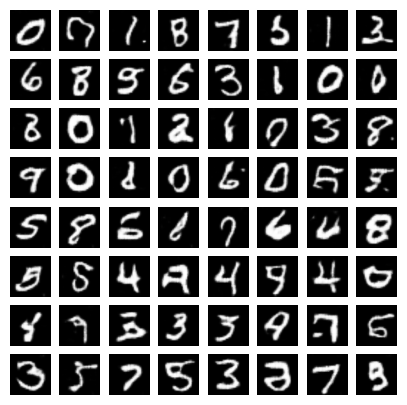



Epoch 9/20
----------
Batch 1/469 : Generator Loss: 4.3713, Discriminator Loss: 0.0283
Batch 201/469 : Generator Loss: 5.9018, Discriminator Loss: 0.0060
Batch 401/469 : Generator Loss: 4.9032, Discriminator Loss: 0.0100
----------
Epoch 9/20 : Generator Loss: 5.0618, Discriminator Loss: 0.0119
Time taken: 0:00:12.866754


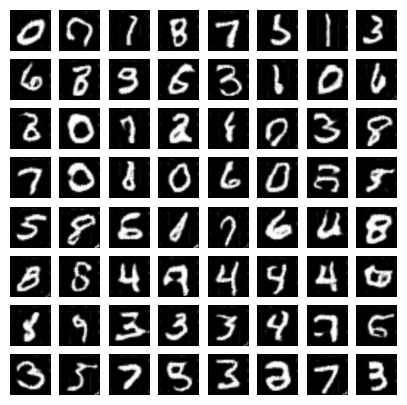



Epoch 10/20
----------
Batch 1/469 : Generator Loss: 7.9351, Discriminator Loss: 0.0034
Batch 201/469 : Generator Loss: 5.3574, Discriminator Loss: 0.0072
Batch 401/469 : Generator Loss: 3.3997, Discriminator Loss: 0.2527
----------
Epoch 10/20 : Generator Loss: 3.5491, Discriminator Loss: 0.2662
Time taken: 0:00:12.940902


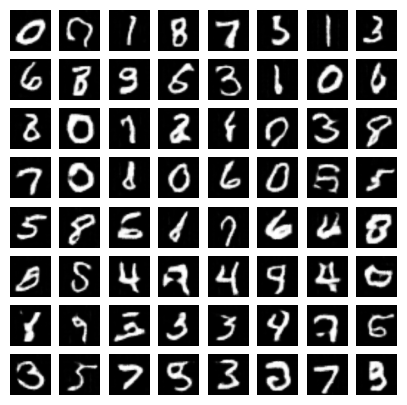



Epoch 11/20
----------
Batch 1/469 : Generator Loss: 2.1640, Discriminator Loss: 0.4723
Batch 201/469 : Generator Loss: 2.4934, Discriminator Loss: 0.2265
Batch 401/469 : Generator Loss: 4.5504, Discriminator Loss: 0.0150
----------
Epoch 11/20 : Generator Loss: 3.5243, Discriminator Loss: 0.1527
Time taken: 0:00:12.975292


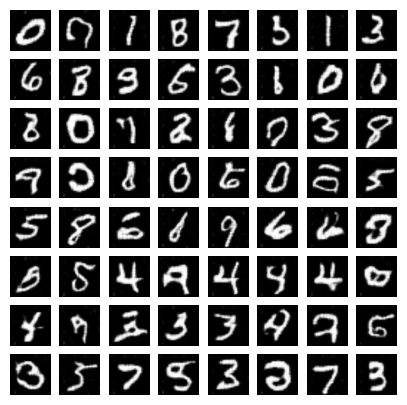



Epoch 12/20
----------
Batch 1/469 : Generator Loss: 4.5415, Discriminator Loss: 0.0138
Batch 201/469 : Generator Loss: 5.3801, Discriminator Loss: 0.0078
Batch 401/469 : Generator Loss: 5.6109, Discriminator Loss: 0.0059
----------
Epoch 12/20 : Generator Loss: 5.3016, Discriminator Loss: 0.0092
Time taken: 0:00:12.956132


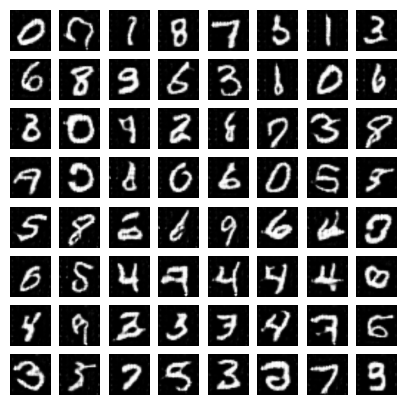



Epoch 13/20
----------
Batch 1/469 : Generator Loss: 5.3121, Discriminator Loss: 0.0076
Batch 201/469 : Generator Loss: 3.2931, Discriminator Loss: 0.2704
Batch 401/469 : Generator Loss: 4.5711, Discriminator Loss: 0.0312
----------
Epoch 13/20 : Generator Loss: 3.6810, Discriminator Loss: 0.1739
Time taken: 0:00:12.952740


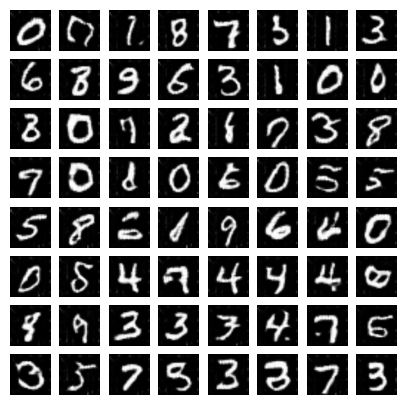



Epoch 14/20
----------
Batch 1/469 : Generator Loss: 5.0248, Discriminator Loss: 0.0077
Batch 201/469 : Generator Loss: 6.0198, Discriminator Loss: 0.0051
Batch 401/469 : Generator Loss: 2.6712, Discriminator Loss: 0.1212
----------
Epoch 14/20 : Generator Loss: 4.2589, Discriminator Loss: 0.1041
Time taken: 0:00:12.814553


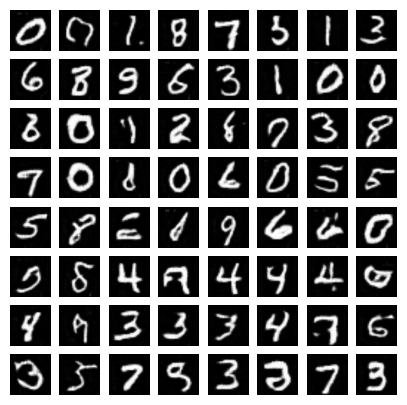



Epoch 15/20
----------
Batch 1/469 : Generator Loss: 4.7487, Discriminator Loss: 0.0959
Batch 201/469 : Generator Loss: 4.9446, Discriminator Loss: 0.0195
Batch 401/469 : Generator Loss: 5.8165, Discriminator Loss: 0.0035
----------
Epoch 15/20 : Generator Loss: 4.5141, Discriminator Loss: 0.0832
Time taken: 0:00:12.911402


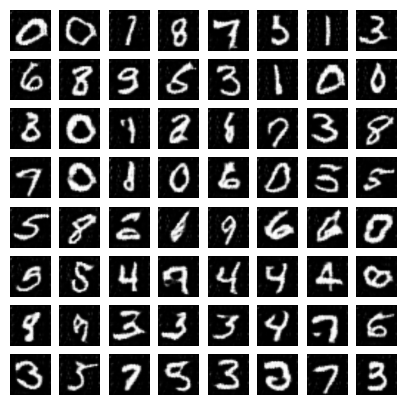



Epoch 16/20
----------
Batch 1/469 : Generator Loss: 5.1500, Discriminator Loss: 0.0086
Batch 201/469 : Generator Loss: 5.7501, Discriminator Loss: 0.0049
Batch 401/469 : Generator Loss: 5.9954, Discriminator Loss: 0.0050
----------
Epoch 16/20 : Generator Loss: 5.8623, Discriminator Loss: 0.0526
Time taken: 0:00:12.852850


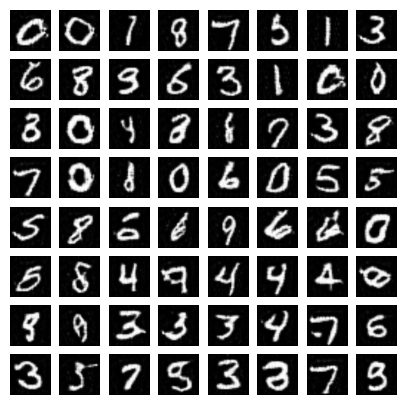



Epoch 17/20
----------
Batch 1/469 : Generator Loss: 2.0203, Discriminator Loss: 0.2889
Batch 201/469 : Generator Loss: 3.3470, Discriminator Loss: 0.1149
Batch 401/469 : Generator Loss: 5.2820, Discriminator Loss: 0.0179
----------
Epoch 17/20 : Generator Loss: 3.3606, Discriminator Loss: 0.2079
Time taken: 0:00:12.912419


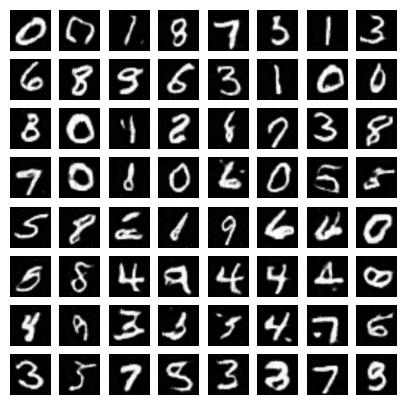



Epoch 18/20
----------
Batch 1/469 : Generator Loss: 2.6290, Discriminator Loss: 0.2846
Batch 201/469 : Generator Loss: 4.5419, Discriminator Loss: 0.0191
Batch 401/469 : Generator Loss: 5.0717, Discriminator Loss: 0.0104
----------
Epoch 18/20 : Generator Loss: 3.9491, Discriminator Loss: 0.1116
Time taken: 0:00:12.859798


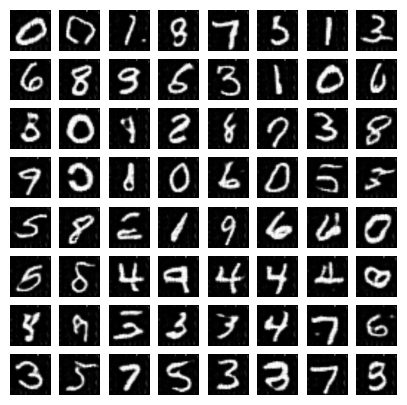



Epoch 19/20
----------
Batch 1/469 : Generator Loss: 5.2833, Discriminator Loss: 0.0075
Batch 201/469 : Generator Loss: 5.5539, Discriminator Loss: 0.0057
Batch 401/469 : Generator Loss: 5.4339, Discriminator Loss: 0.0110
----------
Epoch 19/20 : Generator Loss: 5.7560, Discriminator Loss: 0.0061
Time taken: 0:00:12.871551


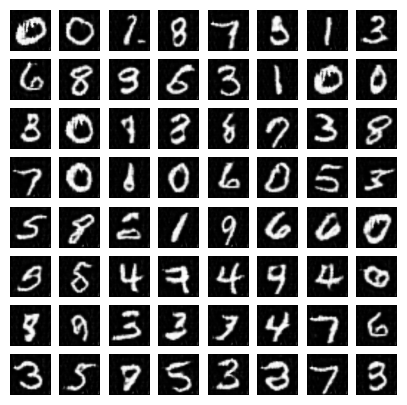



Epoch 20/20
----------
Batch 1/469 : Generator Loss: 6.0173, Discriminator Loss: 0.0031
Batch 201/469 : Generator Loss: 0.8182, Discriminator Loss: 0.6803
Batch 401/469 : Generator Loss: 6.0663, Discriminator Loss: 0.3064
----------
Epoch 20/20 : Generator Loss: 4.1943, Discriminator Loss: 0.2151
Time taken: 0:00:12.897573


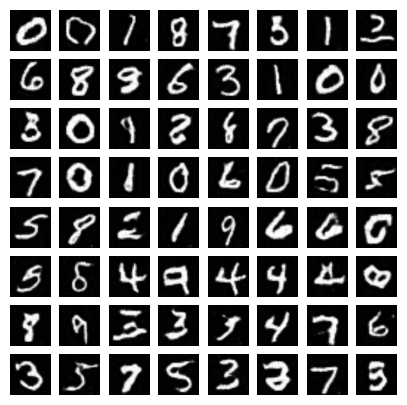

In [10]:
BATCH_SIZE = 128
LATENT_DIM = 100
EPOCHS = 20

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta

# Create empty lists to store the generator and discriminator losses for each epoch
gen_losses_avg = []
disc_losses_avg = []

# Create a fixed noise vector to visualize the progression of the generator every epoch
fixed_latent_vector = torch.randn(64, LATENT_DIM, 1, 1).to(device)

# Training loop
for epoch in range(EPOCHS):
    
    # Record the start time of each epoch
    start_time = time.time()

    num_batches = len(train_loader)

    print("\n")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 10)

    running_generator_loss = 0.0
    running_discriminator_loss = 0.0

    generator.train()
    discriminator.train()

    for batch_idx, (real_image, class_labels) in enumerate(train_loader, start=0):
        real_image = real_image.to(device)

        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
        fake_image = generator(noise)

        # 1.  Discriminator training (maximize log(D(x)) + log(1 - D(G(z))))

        # Discriminator outputs for real and fake images
        real_output = discriminator(real_image).reshape(-1)
        fake_output = discriminator(fake_image).reshape(-1)

        # Discriminator losses for real and fake images
        real_loss = criterion(real_output, torch.ones_like(real_output))
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))

        # Total discriminator loss
        discriminator_loss = (real_loss + fake_loss) / 2

        # Forward + Backward + Optimize (Discriminator)
        optimizer_D.zero_grad()
        discriminator_loss.backward(
            retain_graph=True
        )  # We will use the fake image again, so we need to retain the graph. Otherwise, the graph will be freed by PyTorch.
        optimizer_D.step()

        # 2.  Generator training (maximize log(D(G(z))))
        fake_output = discriminator(fake_image).reshape(-1)
        generator_loss = criterion(fake_output, torch.ones_like(fake_output))

        # Forward + Backward + Optimize (Generator)
        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

        # Print the loss for this batch
        if batch_idx % 200 == 0:
            print(
                f"Batch {batch_idx+1}/{num_batches} : Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}"
            )

        running_generator_loss += generator_loss.item()
        running_discriminator_loss += discriminator_loss.item()

    # Store the loss for this epoch
    gen_losses_avg.append(running_generator_loss / num_batches)
    disc_losses_avg.append(running_discriminator_loss / num_batches)
    
    # Record the end time of each epoch
    end_time = time.time()

    # Print training statistics for this epoch (time taken, generator and discriminator losses)
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Generator Loss: {gen_losses_avg[-1]:.4f}, Discriminator Loss: {disc_losses_avg[-1]:.4f}"
    )
    print(f"Time taken: {timedelta(seconds=end_time-start_time)}")

    # Set the generator and discriminator to eval mode to sample images from noise
    generator.eval()
    discriminator.eval()

    # Sample images from the 'fixed' latent vector
    fake_image = generator(fixed_latent_vector).detach().cpu().numpy()

    # Plot sample images every epoch using matplotlib
    fig = plt.figure(figsize=(5, 5))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_image[i][0], cmap="gray")
        plt.axis("off")
    plt.show()

    # Close the figure to prevent memory leaks
    plt.close(fig)

### Sample images

We will now generate some sample images noise using the trained generator network. Re run the cell to generate new images.

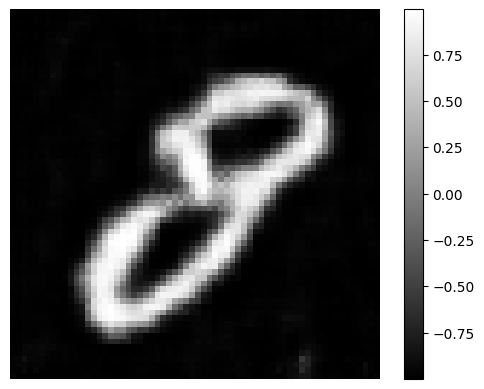

In [21]:
# Generate a random image from a random noise vector
generator.eval()

noise = torch.randn(1, LATENT_DIM, 1, 1).to(device)
fake_image = generator(noise).detach().cpu().numpy()

plt.imshow(fake_image[0][0], cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()


### Plot losses

We will now plot the losses of the generator and discriminator networks during training.

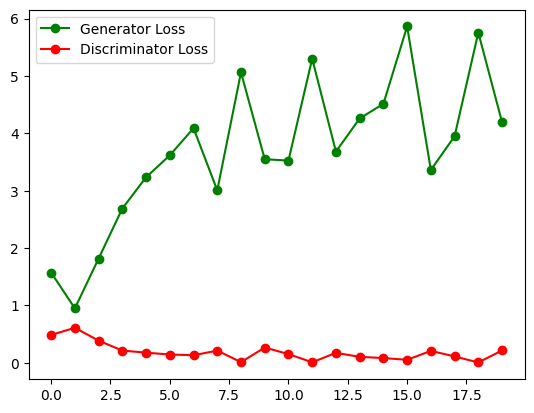

In [22]:
import numpy as np

plt.figure()
plt.plot(np.arange(len(gen_losses_avg)), gen_losses_avg, "g-o", label="Generator Loss")
plt.plot(
    np.arange(len(disc_losses_avg)), disc_losses_avg, "r-o", label="Discriminator Loss"
)
plt.legend()
plt.show()